In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tda, config
import mplfinance as mplf
from datetime import datetime
import numpy as np
import matplotlib.dates as mdates
client = tda.auth.client_from_token_file('kiran.json', config.TD_CLIENT_ID)
from statistics import mean
import tickers
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def draw_bands(tick, length=3, window=60, offset=0, interval='day', exmul=1, verbose = False, result_window=0, vol_avg = 6):
    match interval:
        case 'day':
            bars = client.get_price_history_every_day(tick).json()['candles']
            extrapolation = 1*exmul
        case 'hour':
            bars = client.get_price_history_every_hour(tick).json()['candles']
            extrapolation = (60.0/1440)*exmul
        case '30min':
            bars = client.get_price_history_every_thirty_minutes(tick).json()['candles']
            extrapolation = (30.0/1440)*exmul
        case '15min':
            bars = client.get_price_history_every_fifteen_minutes(tick).json()['candles']
            extrapolation = (15.0/1440)*exmul
        case '10min':
            bars = client.get_price_history_every_ten_minutes(tick).json()['candles']
            extrapolation = (10.0/1440)*exmul
        case '5min':
            bars = client.get_price_history_every_five_minutes(tick).json()['candles']
            extrapolation = (5.0/1440)*exmul
        case 'min':
            bars = client.get_price_history_every_minute(tick).json()['candles']
            extrapolation = (1.0/1440)*exmul
        case _:
            return 'please use a proper interval'
    candles = pd.DataFrame(bars)
    candles.datetime = candles.datetime.apply(lambda x: datetime.fromtimestamp(x/1000))
    candles['vol_avg'] = candles.rolling(vol_avg).mean()['volume'].fillna(0)
    candles = candles[['datetime','open','high','low','close','volume','vol_avg']]
    candles.index = candles.datetime
    lowlist, highlist = [],[]
    adjustedcandles = candles.iloc[-(window+offset):min(-1,-offset)]
    adjustedcandleswindow = candles.iloc[-(window+offset):min(-1,-(offset-result_window))]
    for x in range(adjustedcandles.shape[0]-length):
        if adjustedcandles.iloc[x]['low'] == min(adjustedcandles.iloc[max(x-length,0):min(x+length+1,adjustedcandles.__len__()-1)]['low']):
            lowlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].low))
        if adjustedcandles.iloc[x]['high'] == max(adjustedcandles.iloc[max(x-length,0):min(x+length+1,adjustedcandles.__len__()-1)]['high']):
            highlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].high))
    highs = [x[1] for x in highlist]
    highdates = mdates.date2num([x[0] for x in highlist])
    lows = [x[1] for x in lowlist]
    lowdates = mdates.date2num([x[0] for x in lowlist])
    hab,hr,_,_,_ = np.polyfit(highdates,highs,1,full=True)
    lab,lr,_,_,_ = np.polyfit(lowdates,lows,1,full=True)
    ha,hb = hab
    la,lb = lab
    highdates = np.append(highdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    highdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],highdates)
    lowdates = np.append(lowdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    lowdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],lowdates)
    searr = np.array([mdates.date2num(adjustedcandles.iloc[0].datetime),mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    hregpoints = (ha*highdates)+hb
    lregpoints = (la*lowdates)+lb
    hreglist = [(mdates.num2date(highdates[x]),hregpoints[x]) for x in range(len(hregpoints))]
    lreglist = [(mdates.num2date(lowdates[x]),lregpoints[x]) for x in range(len(lregpoints))]
    havdif = abs(mean([(hregpoints[x]-highs[x-1])/hregpoints[x] for x in range(1,len(hregpoints)-2)]))
    lavdif = abs(mean([(lregpoints[x]-lows[x-1])/lregpoints[x] for x in range(1,len(lregpoints)-2)]))
    vavg = mplf.make_addplot(adjustedcandleswindow['vol_avg'], color='b',panel = 1)
    if verbose: 
        mplf.plot(adjustedcandleswindow,alines=dict(alines=[lreglist,hreglist],colors=['r','g']),type='candle',volume=True, style="yahoo", addplot= vavg)
    return (ha*(highdates[-1]+extrapolation)+hb,(la*(lowdates[-1]+extrapolation)+lb)),havdif,lavdif,(ha,la)

In [3]:
def draw_bands_df(bars, length=3, window=60, offset=0, interval='day', exmul=1, verbose = False, result_window=0, vol_avg=10):
    match interval:
        case 'day':
            extrapolation = 1*exmul
        case 'hour':
            extrapolation = (60.0/1440)*exmul
        case '30min':
            extrapolation = (30.0/1440)*exmul
        case '15min':
            extrapolation = (15.0/1440)*exmul
        case '10min':
            extrapolation = (10.0/1440)*exmul
        case '5min':
            extrapolation = (5.0/1440)*exmul
        case 'min':
            extrapolation = (1.0/1440)*exmul
        case _:
            return 'please use a proper interval'
    candles = pd.DataFrame(bars)
    candles.datetime = candles.datetime.apply(lambda x: datetime.fromtimestamp(x/1000))
    candles['vol_avg'] = candles.rolling(vol_avg).mean()['volume'].fillna(0)
    candles = candles[['datetime','open','high','low','close','volume','vol_avg']]
    candles.index = candles.datetime
    lowlist, highlist = [],[]
    adjustedcandles = candles.iloc[-(window+offset):min(-1,-offset)]
    adjustedcandleswindow = candles.iloc[-(window+offset):min(-1,-(offset-result_window))]
    for x in range(adjustedcandles.shape[0]-length):
        if adjustedcandles.iloc[x]['low'] == min(adjustedcandles.iloc[max(x-length,0):min(x+length+1,adjustedcandles.__len__()-1)]['low']):
            lowlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].low))
        if adjustedcandles.iloc[x]['high'] == max(adjustedcandles.iloc[max(x-length,0):min(x+length+1,adjustedcandles.__len__()-1)]['high']):
            highlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].high))
    highs = [x[1] for x in highlist]
    highdates = mdates.date2num([x[0] for x in highlist])
    lows = [x[1] for x in lowlist]
    lowdates = mdates.date2num([x[0] for x in lowlist])
    hab,hr,_,_,_ = np.polyfit(highdates,highs,1,full=True)
    lab,lr,_,_,_ = np.polyfit(lowdates,lows,1,full=True)
    ha,hb = hab
    la,lb = lab
    highdates = np.append(highdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    highdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],highdates)
    lowdates = np.append(lowdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    lowdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],lowdates)
    searr = np.array([mdates.date2num(adjustedcandles.iloc[0].datetime),mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    hregpoints = (ha*highdates)+hb
    lregpoints = (la*lowdates)+lb
    hreglist = [(mdates.num2date(highdates[x]),hregpoints[x]) for x in range(len(hregpoints))]
    lreglist = [(mdates.num2date(lowdates[x]),lregpoints[x]) for x in range(len(lregpoints))]
    havdif = abs(mean([(hregpoints[x]-highs[x-1])/hregpoints[x] for x in range(1,len(hregpoints)-1)]))
    lavdif = abs(mean([(lregpoints[x]-lows[x-1])/lregpoints[x] for x in range(1,len(lregpoints)-1)]))
    vavg = mplf.make_addplot(adjustedcandleswindow['vol_avg'], color='b',panel = 1)
    if verbose: 
        mplf.plot(adjustedcandleswindow,alines=dict(alines=[lreglist,hreglist],colors=['r','g']),type='candle',volume=True, style="yahoo", addplot=vavg)
    return (ha*(highdates[-1]+extrapolation)+hb,(la*(lowdates[-1]+extrapolation)+lb)),havdif,lavdif,(ha,la), (hb,lb)

In [4]:
def draw_bands_datetime(df, start, end, target:datetime, length=3):
    candles = pd.DataFrame(df)
    candles.datetime = candles.datetime.apply(lambda x: datetime.fromtimestamp(x/1000))
    candles = candles[['datetime','open','high','low','close','volume']]
    candles.index = candles.datetime
    lowlist, highlist = [],[]
    adjustedcandles = candles.where(candles.datetime>=start).dropna()
    adjustedcandles = adjustedcandles.where(candles.datetime<=end).dropna()
    for x in range(length,adjustedcandles.shape[0]-length):
        if adjustedcandles.iloc[x]['low'] == min(adjustedcandles.iloc[x-length:x+length+1]['low']):
            lowlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].low))
        if adjustedcandles.iloc[x]['high'] == max(adjustedcandles.iloc[x-length:x+length+1]['high']):
            highlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].high))
    highs = [x[1] for x in highlist]
    highdates = mdates.date2num([x[0] for x in highlist])
    lows = [x[1] for x in lowlist]
    lowdates = mdates.date2num([x[0] for x in lowlist])
    hab,hr,_,_,_ = np.polyfit(highdates,highs,1,full=True)
    lab,lr,_,_,_ = np.polyfit(lowdates,lows,1,full=True)
    ha,hb = hab
    la,lb = lab
    highdates = np.append(highdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    highdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],highdates)
    lowdates = np.append(lowdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    lowdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],lowdates)
    searr = np.array([mdates.date2num(adjustedcandles.iloc[0].datetime),mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    hregpoints = (ha*searr)+hb
    lregpoints = (la*searr)+lb
    hreglist = [(mdates.num2date(searr[x]),hregpoints[x]) for x in range(2)]
    lreglist = [(mdates.num2date(searr[x]),lregpoints[x]) for x in range(2)]
    mplf.plot(adjustedcandles,alines=dict(alines=lreglist,colors=['r']),type='candle')
    mplf.plot(adjustedcandles,alines=dict(alines=hreglist,colors='g'),type='candle')
    return 1/(hr/(np.mean(hregpoints)**2)),1/(lr/(np.mean(lregpoints)**2)),ha*(mdates.date2num(target))+hb,la*(mdates.date2num(target))+lb

In [6]:
bars = client.get_price_history_every_minute("AAL", need_extended_hours_data=False).json()['candles']
for o in range(500,90,-1):
    try:
        (_,_),dh,dl,(ha,la) = draw_bands_df(bars,interval='min',length=7, offset = o, window = 65, exmul = 20, vol_avg = 2)
        if ha<0 and la<0 and la/ha<.5 and dl<.0005 and dh<.0005 and la>ha:
            print(draw_bands_df(bars,interval='min',length=7, offset = o, window = 65, exmul = 20, verbose = True, result_window=40, vol_avg = 2))
    except:
        continue
print("Done")

Done


In [ ]:
draw_bands_df(bars,interval='min',length=7, offset = 40, window = 65, exmul = 20, verbose = True, result_window=40, vol_avg = 2)

In [15]:
def draw_bands_df_vpc(bars, length=3, window=60, offset=0, interval='day', exmul=1, verbose = False, result_window=0, vol_avg=10, vol_pct = .05):
    match interval:
        case 'day':
            extrapolation = 1*exmul
        case 'hour':
            extrapolation = (60.0/1440)*exmul
        case '30min':
            extrapolation = (30.0/1440)*exmul
        case '15min':
            extrapolation = (15.0/1440)*exmul
        case '10min':
            extrapolation = (10.0/1440)*exmul
        case '5min':
            extrapolation = (5.0/1440)*exmul
        case 'min':
            extrapolation = (1.0/1440)*exmul
        case _:
            return 'please use a proper interval'
    candles = pd.DataFrame(bars)
    candles.datetime = candles.datetime.apply(lambda x: datetime.fromtimestamp(x/1000))
    candles['vol_avg'] = candles.rolling(vol_avg).mean()['volume'].fillna(0)
    candles = candles[['datetime','open','high','low','close','volume','vol_avg']]
    candles.index = candles.datetime
    lowlist, highlist = [],[]
    adjustedcandles = candles.iloc[-(window+offset):min(-1,-offset)]
    adjustedcandleswindow = candles.iloc[-(window+offset):min(-1,-(offset-result_window))]
    for x in range(adjustedcandles.shape[0]-length):
        if adjustedcandles.iloc[x]['low'] == min(adjustedcandles.iloc[max(x-length,0):min(x+length+1,adjustedcandles.__len__()-1)]['low']):
            lowlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].low))
        if adjustedcandles.iloc[x]['high'] == max(adjustedcandles.iloc[max(x-length,0):min(x+length+1,adjustedcandles.__len__()-1)]['high']):
            highlist.append((str(adjustedcandles.iloc[x].datetime),adjustedcandles.iloc[x].high))
    highs = [x[1] for x in highlist]
    highdates = mdates.date2num([x[0] for x in highlist])
    lows = [x[1] for x in lowlist]
    lowdates = mdates.date2num([x[0] for x in lowlist])
    hab,hr,_,_,_ = np.polyfit(highdates,highs,1,full=True)
    lab,lr,_,_,_ = np.polyfit(lowdates,lows,1,full=True)
    ha,hb = hab
    la,lb = lab
    highdates = np.append(highdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    highdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],highdates)
    lowdates = np.append(lowdates,[mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    lowdates = np.append([mdates.date2num(adjustedcandles.iloc[0].datetime)],lowdates)
    searr = np.array([mdates.date2num(adjustedcandles.iloc[0].datetime),mdates.date2num(adjustedcandles.iloc[-1].datetime)])
    hregpoints = (ha*highdates)+hb
    lregpoints = (la*lowdates)+lb
    hreglist = [(mdates.num2date(highdates[x]),hregpoints[x]) for x in range(len(hregpoints))]
    lreglist = [(mdates.num2date(lowdates[x]),lregpoints[x]) for x in range(len(lregpoints))]
    havdif = abs(mean([(hregpoints[x]-highs[x-1])/hregpoints[x] for x in range(1,len(hregpoints)-1)]))
    lavdif = abs(mean([(lregpoints[x]-lows[x-1])/lregpoints[x] for x in range(1,len(lregpoints)-1)]))
    vavg = mplf.make_addplot(adjustedcandleswindow['vol_avg'], color='b',panel = 1)
    highvol = adjustedcandleswindow.volume.quantile(vol_pct)
    hvol = mplf.make_addplot([highvol]*len(adjustedcandleswindow), color = 'y', panel= 1)
    if verbose: 
        mplf.plot(adjustedcandleswindow,alines=dict(alines=[lreglist,hreglist],colors=['r','g']),type='candle',volume=True, style="yahoo", addplot=[vavg,hvol])
    return (ha*(highdates[-1]+extrapolation)+hb,(la*(lowdates[-1]+extrapolation)+lb)),havdif,lavdif,(ha,la),(hb,lb), hvol

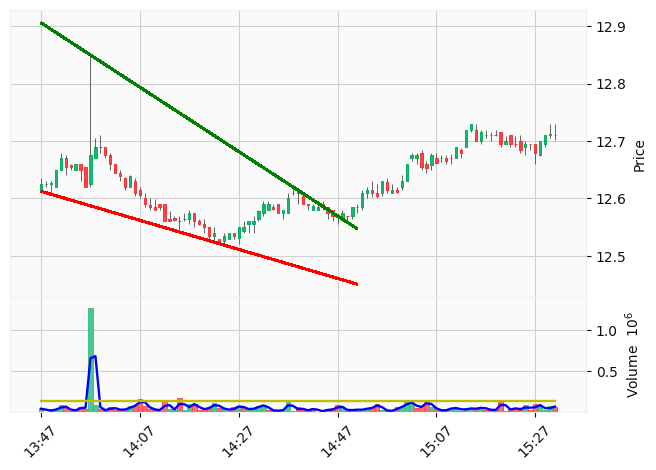

((12.434878048778046, 12.399904969308409),
 4.2040364870561324e-14,
 1.0929167768749105e-10,
 (-8.078048780224828, -3.643476539436197))

In [17]:
draw_bands_df_vpc(bars,interval='min',length=7, offset = 100, window = 65, exmul = 20, verbose = True, result_window=40, vol_avg = 2, vol_pct = .95)

V
Not enough points
CVX
ATVI
CAT
ORCL
PFE
AAPL
GME
MSFT
AMD
S
-2.0980132455458653 -4.863679767093049e-12
Not enough points
KO
AMZN
LCID
F
CSCO
GM
Not enough points
CMCSA
EBAY
DIS
PTON
TWTR
HD
SBUX
SNAP
SQ
-3.1813953486356334 -2.76923077168864


/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/mplfinance/_utils.py:228: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  d1s = dtseries.loc[date:]
/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/mplfinance/_utils.py:233: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  d2s = dtseries.loc[:date]
/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/mplfinance/_utils.py:237: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  d2 = dtseries.loc[:date].index[-1]


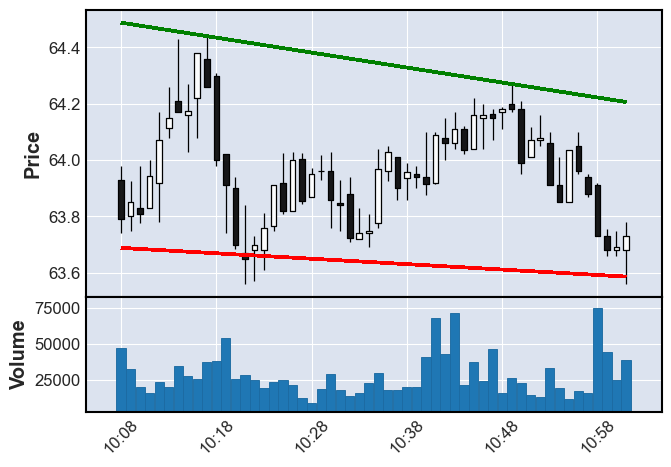

((64.10000000003492, 63.54794871784543), 0.002638112972894151, 0.000798075484357102, (-7.649999998386522, -2.76923077168864))
BABA
AFRM
SOFI
F
BA
CAT
LOW
ATVI
PFE
NIO
NVDA
JPM
PEP
WFC
AAL
NKE
VZ
Not enough points
MRVL
PYPL
ABNB
LCID
DASH
-10.356056872696957 -9.000939948825952


/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/mplfinance/_utils.py:228: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  d1s = dtseries.loc[date:]
/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/mplfinance/_utils.py:233: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  d2s = dtseries.loc[:date]
/Users/kiran/opt/anaconda3/envs/p310/lib/python3.10/site-packages/mplfinance/_utils.py:237: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  d2 = dtseries.loc[:date].index[-1]


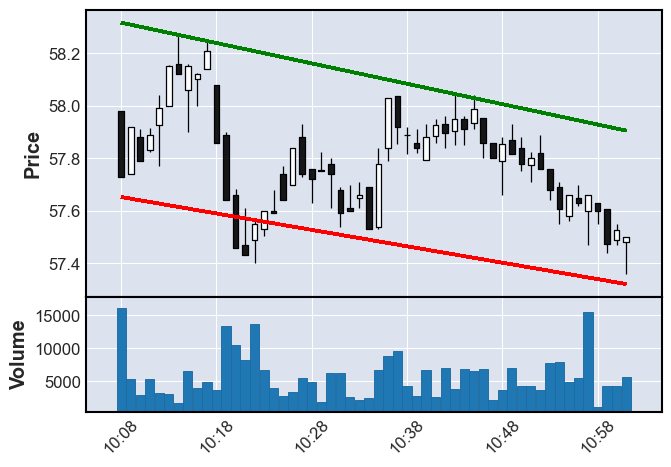

((57.75017241376918, 57.195900783204706), 0.0038613351617229376, 0.001425259026717426, (-11.172413790625024, -9.000939948825952))
LYFT
UBER
CSCO
MS
RBLX
MU
BAC
MRNA
NEGG
PG


In [16]:
for x in tickers.ticklist:
    print(x)
    for o in range(1000):
        try:
            (_,_),dh,dl,(ha,la) = draw_bands(x,interval='min',length=7, offset = 0, window = 55, exmul = 20)
            if ha<0 and la<0 and abs(la-ha)>abs(.1*ha) and dl<.01 and dh<.01 and la>ha:
                print(ha,la)
                print(draw_bands(x,interval='min',length=7, offset = 0, window = 55, exmul = 20, verbose = True))
        except:
            print("Not enough points")